In [1]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics

In [2]:
np.random.seed(42)  # do not change for reproducibility

In this test we use the [Covertype Data Set](http://archive.ics.uci.edu/ml/datasets/Covertype), a dataset describing cartographic 
features of areas of land in the USA and also its forest type according to the US Forest Service. 
There are seven classes (1-7), 581012 samples and 54 features.
For this test, we're only interested in cover type 3.




In [3]:
dataset = sklearn.datasets.fetch_covtype()

In [4]:
# only use a random subset for speed - pretend the rest of the data doesn't exist
random_sample = np.random.choice(len(dataset.data), len(dataset.data) // 10)

COVER_TYPE = 3
features = dataset.data[random_sample, :]
target = dataset.target[random_sample] == COVER_TYPE

A junior colleague tells you that they're getting 96% accuracy using logistic regression. You review their work and see the following:

In [5]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear') # do not change this


In [6]:
classifier.fit(features,  target)
training_predictions = classifier.predict(features)
accuracy = sklearn.metrics.accuracy_score(training_predictions, target)

In [7]:
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.959


**Question 1**

Comment on what was done above. Evaluate the accuracy more thoroughly. Do not modify the parameters of the model (the cell marked with the comment). Use the classifier object.

In [8]:
### Write your code and explanation here. INCLUDE ALL ANALYSIS ETC. YOU USE

***

#### Answer to Question 1

#### Introduction:

From my perspective, the following points are not being thoroughly considered or applied and can be utilised to achieve a better result regarding the classification of the presented dataset. 

Possible issues regarding the performed classification test above: 
- There is no evidence of any data exploration/profiling prior to performing the classification. 
- The lack of data exploration has led to a significant issue, namely using “accuracy score” as the metric for an “imbalanced” dataset.
- The model has been evaluated on the same dataset that is used for training, instead of using a dedicated validation or test dataset.

In the following, these issues will be discussed in detail. Additional comments will be presented on why and how these can be avoided, including my preferred approach, following by a short summary.  

#### Outlook:
 
[__1.1. Data exploration__](#Data-exploration)

[__1.2. Training and test dataset split__](#Dataset-split)  

[__1.3. Model evaluation__](#Model-evaluation)

In [9]:
# Import standard packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 1.1. Data exploration
 
Best practices to tackle machine learning problems suggest exploratory data analysis as the first step. Based on the scope of the analysis regarding time and/or budget, and expected performance, one can decide to which extend subsequent data cleaning and feature engineering/selection must be performed. Note that it the entire process is iterative. 

For the task at hand, I prefer pandas profiling as the chosen exploratory data analysis approach. Pandas profiling depicts almost all the critical information regarding the dataset (from data types to variable distribution, correlations, missing or duplicated data, etc.) in one simple step. This helps not only to have a better overall understanding of the data and its nature, but also the stored report can be used in further steps.  

<div class="alert alert-block alert-info">
<b>Note:</b> The result of the pandas profile report is stored in <b>./outputs/pandas_profile_report.htm</b>. Therefore, in order to save time and avoid installation of an additional package, the execution of the cells marked by <b>OPTIONAL</b> can be omitted.
</div>

In [10]:
# Fetch the dataset as a pandas data frame
df_X, df_y = sklearn.datasets.fetch_covtype(return_X_y=True, as_frame=True) 
df = pd.concat([df_X, df_y], axis=1)

# Re-create the same random subset as was used above
df_random = df.loc[random_sample, :]
df_random['Cover_Type'] = df_random['Cover_Type'] == COVER_TYPE

# Check if the number of samples is the same as was used above
assert df_random.shape[0] == features.shape[0]

In [11]:
# OPTINAL: Run this cell only if you want to reproduce the pandas-profiling report

# Install pandas-profiling
#!pip install pandas-profiling

# Troubleshooting: uncomment if needed
#!pip install markupsafe==2.0.1

from pandas_profiling import ProfileReport

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/sara/.local/lib/python3.8/site-packages/missingno/missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/Users/sara/.local/lib/python3.8/site-packages/pandas_profiling/model/missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (55).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

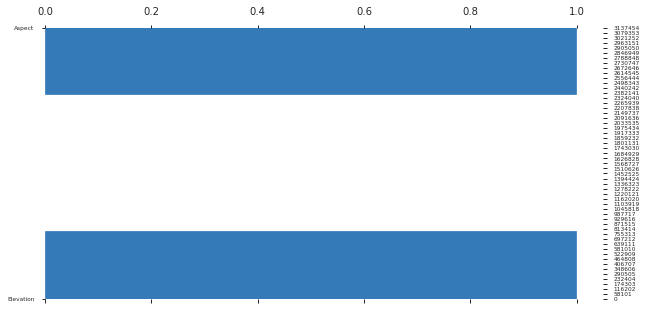

In [12]:
# OPTINAL: Run this cell only if you want to reproduce the pandas-profiling report

# Data exploration using pandas_profiling:

# Let's first remove the indices, otherwise pandas-profiling analyses them as a variable 
df_random_no_index = df_random.reset_index(drop=True, inplace=False)

# Produce the report and save it in html format
profile = ProfileReport(df_random_no_index)
profile.to_file(output_file='./outputs/pandas_profile_report.html')

#NOTE: The error message concerning "missing value diagram" not being generated can be ignored. 
#      In the produced profile report it can be seen that no variable has any missing value, so
#      a summary missing value diagram is not needed.

__Data quality:__

The profile report reveals that **the dataset is fairly clean**. There is no need for converting data types, nor any evidence of outliers and missing or corrupted data. 

The existence of duplicated rows, with an amount of 4.6%, is not an issue that required to be delt with at this stage. If the duplicates only appear in the training dataset, they should not be dropped. Because they are "true" duplicates and their repetitions provide weight of evidence and the frequency information is important. However, it shall be noted that it is important not to have duplicates between training and test data. 

__Features:__

From 54 feature variables, around 44 are categorical with discrete values of 0 and 1. The remaining features are qualitative with various ranges, some of which are clearly not normally distributed, and some have zero values that must be retained. 

I recommend to perform mean-max scaling on the qualitative features to scale them to a range of \[0, 1\]. Working with features in the same scale not only can improve the modelling results, but also is required if later feature selection is performed based on feature importance in modelling. 

It is important to **perform the feature scaling after dataset is split into training and test datasets**, using only the data from the training set. For an unbiased evaluation, the model which is being trained on the training dataset, must be totally blinded to the test dataset, which as explained in section [1.2](#Dataset-split), plays the role of fresh unseen data. But scaling the features before splitting will leak the information about the characteristics of the feature distributions in the test dataset into the training data. 

__Target:__

One piece of crucial information about the dataset comes from the Boolean target variable, called `Cover_Type` (please refer the `./outputs/pandas_profile_report.html` file or the screenshot inserted below). 

One can see that this is a dataset with **"skewed"** or **"imbalanced"** classes. An imbalanced dataset has an unequal distribution of the classes, where one or more classes might be in a minority and the others in majority. Here, the samples with positive labels, with a ratio of 6%, form the minority class, and the negative samples are the majority. 

Dealing with imbalanced datasets requires to address three main issues: 
- Choosing proper evaluation metric
- If the minority class occurs rarely, the model does not have a good chance to learn it
- Many of the algorithms are initially designed for equally balanced classes

For the task at hand, the first issues is addressed in section [1.3](#Model-evaluation) and the second and third in [answer to question 2](#Answer-to-Question-2).

<img src="images/Screenshot _target_overview.png">

As a side note, the case of imbalance data could have easily been revealed from the original dataset used above, without pandas profiling, from a very simple check as below: 

Positive label rate: 0.06
Negative label rate: 0.94


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


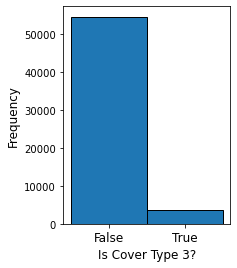

In [13]:
# Perform a simple check on ratio of target labels, using the original data used above
pos_target = target[target == True]
neg_target = target[target == False]

print(f'Positive label rate: {(pos_target.shape[0] / target.shape[0]):.2f}')
print(f'Negative label rate: {(neg_target.shape[0] / target.shape[0]):.2f}') 

# Visualisation:  
fig, ax = plt.subplots(figsize=(3,4))

bins = [0, 1, 2]
nbins = len(bins) - 1

_, _, patches = plt.hist(target, bins=bins, edgecolor='black')

ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [bool(i) for i in range(nbins)]
plt.xticks(ticks, ticklabels, fontsize=12)

ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Is Cover Type 3?', fontsize=12)

plt.show()

#### 1.2. Dataset split 

An accurate evaluation of the model and diagnosis of overfitting requires splitting the dataset into training, validation, and test data. The training dataset should only be used for training the model, the validation data for evaluation the model after tuning each of the hyperparameters in order to decide about the best performed hyperparameter setup, and the test data for the final reveal of how well the predictions by the model generalised to the unseen data (i.e., real world data).

Here, since there is not going to be much of hyperparameter tuning and model comparison, and since the dataset is not very large and is also unbalanced (therefore the minority class has even smaller number of samples), we can get away by splitting the data only into a training and a test set.  

In [14]:
# Splitting the dataset into 75% trainning data and 25% test data
df_train, df_test = train_test_split(df_random, test_size=0.25)

In [15]:
# Separate features and targets, since it is needed for the next steps:

df_train_features = df_train.drop(['Cover_Type'], axis=1)
df_train_target = df_train.loc[:, 'Cover_Type']

df_test_features = df_test.drop(['Cover_Type'], axis=1)
df_test_target = df_test.loc[:, 'Cover_Type']

In [16]:
# Print training and test dataset shapes

print('Shape of features of training set:', df_train_features.shape)
print('Shape of targets of training set:', df_train_target.shape)

print('Shape of features of test set:', df_test_features.shape)
print('Shape of targets of test set:', df_test_target.shape)

Shape of features of training set: (43575, 54)
Shape of targets of training set: (43575,)
Shape of features of test set: (14526, 54)
Shape of targets of test set: (14526,)


#### 1.3. Model evaluation

As showed in section [1.1](#Data-exploration), the dataset has imbalanced classes. Accuracy score is a misleading metric for imbalanced data. 

In the case shown in question 1, consider a classification that always predicts a negative for any samples. Even though this would have been a very bad classification job, the accuracy score would have been as high as 94%, which is simply the rate of negative labels.

In [17]:
print(f'''Accuracy score, if all predictions were negative: 
{sklearn.metrics.accuracy_score(target, np.zeros_like(target, dtype=bool)):.3f}''')

Accuracy score, if all predictions were negative: 
0.939


More suitable metrics for evaluating imbalanced data are:

- Confusion Matrix
- Precision-Recall Curve
- F1 score

In the following, each of these metrics are performed and discussed, using the same classification object as above. But first, the classifier is fitted to the training data, and then the predictions of the classifier over the test dataset are used for evaluation, as this is the more correct approach.

In [18]:
# Fit the logistics regression classifier defined above to training data only
classifier.fit(df_train_features, df_train_target)

# Get the predictoins for the test data, to be used for evaluation 
test_predictions = classifier.predict(df_test_features)

__Confusion Matrix:__

In a binary classification, such as the task at hand, the predictions are compared to the actual (i.e., ground truth) labels to get the confusion matrix as below:

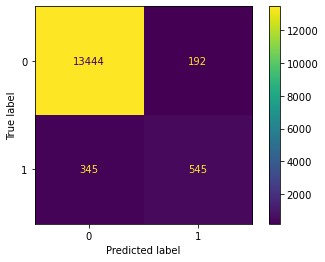

In [19]:
# Plotting the confusion matrix
cm = sklearn.metrics.confusion_matrix(df_test_target, test_predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

For the minority class (i.e. positive, or 1), the classifier is able to predict 499 correct out of 860 samples, i.e. a 58% rate. For majority class, model got only 223 predictions wrong, equivalent to less than 2%. It is not surprising than the model has performed better on the majority class.

Confusion matrix is a good way for visualising the distribution of all the four possible outcomes of the classification (i.e., true negatives, false negatives, true positives, and false positives). It gives a good overview of how well a model is doing. However, when it comes to comparing the performance of different models, or different settings of hyperparameters, it is more practical to have only one metric value. Therefore, the confusion matrix is better to be used just as a starting point for model evaluation.

__Precision-Recall Curve:__

Two useful and intuitive metrics for classification are **precision** and **recall** scores. 
Precision is a measure of how accurate the prediction of a specific class by the classifier is, and recall is a measure of the ability of the classifier to identify a class.

If the classifier handles the data perfectly, both precision and recall scores are high. But there is a trade-off between the two scores, depending on the threshold applied on the prediction probability, based on which a prediction is classified as a positive or a negative class. Sometimes the business is more sensitive toward either of the recall or precision scores, so we can target for that specific score. Otherwise, the two scores are needed to be checked together. 

One way to summarise the two scores is plotting the pair of scores against different choices of probability threshold, which is called the **Precision-Recall curve (PR curve)**. The PR curve can help to choose a suitable probability threshold that fulfils the objective of the analysis better. Also, comparing the RC curves of different models reveals the better performed model. 

A very similar concept to PR curve is the **ROC curve**, which instead of precision and recall, shows the true and false positive rates against the probability threshold. The **area under the ROC (AUC)** can also be exploited as another metric. If we want to compare different classifier models, it is usually sufficient to use only one of the PR or ROC curves. A curve dominates in ROC space only and only if it dominates in PR space. But the PR curve is more informative than the ROC curve when applied to imbalanced datasets.

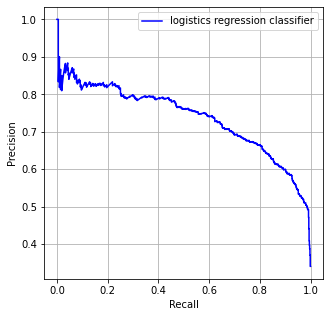

In [20]:
# Get the probability values for the test dataset, according to the logistics regression classifier defined above
test_probs = classifier.predict_proba(df_test_features)

# Plot the precision_recall curve
precision, recall, _ =  sklearn.metrics.precision_recall_curve(df_test_target, test_probs[:,1])

fig, _ = plt.subplots(figsize=(5,5))

plt.plot(recall, precision, color = 'blue', label = 'logistics regression classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

The RC curve above indicates that the classifier has a performance yet far from perfect if the objective is to have both high precision and recall scores. For that objective, the closer the curve gets to the point (1, 1) at the top right corner of the plot, the better performance it has. 

__F1 score:__

F1 score of a class is nothing but a harmonic weighted mean of precision and recall. It provides a one-value metric, which as mentioned before is more practical and therefore desired, where the recall and the precision scores are equally important. So it is a great metric for business problems that do not have more sensitivity toward one of the two scores. 

F1 scored is calculated as: 

$F_{1} = \frac{2~\times~precision~\times~recall}{precision~+~recall}$, 

and reaches its best value at 1, and its worst score at 0.

In [21]:
# F1 score
f1 = sklearn.metrics.f1_score(df_test_target, test_predictions)
print(f'F1 score of the test dataset: {f1:.2f}')

F1 score of the test dataset: 0.67


The downside of F1 score is that it might not be as intuitive as accuracy or precision scores. Here we achieved a 0.63 score, yet it is not totally intuitive and comprehensive how bad or how good is this value for this score. When comparing the performance of two classification models, of course this is not a concern, the higher the F1 score, the better is the model (with the assumption that precision and recall are equally important for us). 

***End of Answer to Question 1***
***

**Question 2**

Should you get more training data?

In [22]:
### Write your code and explanation here.

***
#### Answer to Question 2

There are a few points that should be considered to answer this question:

1. One could expect that more training data can be helpful to achieve better results, since the model is able to see more examples of the minority class and perform better for that class. It would have been more true for a severely imbalanced dataset, where the minority class has less than 1% rate. But in our case, with around 6% ratio for the minority class, and a training sample size of around 40k, the effect of more training data might not be as obvious. 


2. Furthermore, after getting more training data the dataset still remains imbalanced, affected by the other important issue of the imbalanced datasets: The fact that most algorithms are designed for balanced classes, including the logistic regression classification which is chosen as the primary model here.

    Some classification algorithms have ways to "adjust" the importance of the classes, by giving different weights to the majority and minority classes during the training phase. The idea is to more penalize the misclassification error in the minority class, by setting higher weights to them and at the same time reducing the weights of the majority class. For example, this adjustment for the logistic regression classification can be done by simply setting `class_weights = ‘balanced’` for the classifier object:
    
    <code>classifier = sklearn.linear_model.LogisticRegression(solver='liblinear', class_weight='balanced'</code>


3. An alternative to adjusting algorithms is data sampling and augmentation. The goal is to make the training dataset more balanced, by either under-sampling the majority class (i.e., randomly removing data points from majority class), over-sampling the minority class (randomly duplicating data points in minority class), or by adding synthetic data points to the minority class, with a similar distribution of the original data points in the minority class (e.g., the SMOTE method). 

Considering the above points, I would recommend the following workflow:

First, compare the performance of different classifying algorithms, such as Gradient Boosting Classifier and weighted logistic regression (i.e., adjusted logistic regression algorithm). After settling the best algorithm choice, gradually introduce more training data and examine if the performance improves on a validation or test dataset. Then, depending on the scope of the analysis regarding time, budget, and expected performance, one can decide if getting more training data provides a reasonable cost-benefit ratio. I would leave the data sampling and augmentation to the last step of the workflow, getting utilised only if previous steps have not achieved the desired performance. 

***End of Answer to Question 2***
***

**Question 3**

How would you decide which features to include in the deployed model?

In [23]:
### Write your code and explanation here.

***
#### Answer to Question 3

The answer to this question depends heavily on the objective of the analysis. The dataset that is used is not a wide or high-dimensional dataset. In such cases, feature selection most likely does not improve the model performance or speed significantly. Also, implementing traditional feature selection methods should be done cautiously for imbalanced datasets, as they might add bias towards the majority class. Additionally, the features are dominantly categorical variables with discrete values of 0 and 1, which will limit the interesting statistical characteristics that can be used in feature selection approaches based on filter methods.   

Considering the above points, for the task at hand I would suggest investing time and effort on feature selection only if the desired performance could not be achieved by trying out more model tuning. In this case, I will start by performing rather cost- and interpretation-friendly, and less complicated approaches, such as L1-based feature selection or utilising tree-based estimators. 

***End of Answer to Question 3***
***